In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_curve, auc,classification_report

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from math import sqrt


plt.rcParams['font.sans-serif'] = ['simhei']
plt.rcParams['font.serif'] = ['simhei']
plt.rcParams['axes.unicode_minus']=False # 默认是使用Unicode负号，设置正常显示字符，如正常显示负号

import seaborn as sns
sns.set_style("darkgrid",{"font.sans-serif":['simhei','Droid Sans Fallback']})
import pandas as pd


In [3]:
data=pd.read_csv('A题-全部数据/附件3/M301.csv')
data.head()

日期  时间 生产线编号  物料推送气缸推送状态  物料推送气缸收回状态  物料推送数  物料待抓取数  放置容器数  容器上传检测数  填装检测数  \
0   1   0  M301           0           1      0       0      0        0      0   
1   1   1  M301           1           0      1       0      0        0      0   
2   1   2  M301           0           1      1       0      0        0      0   
3   1   3  M301           1           0      2       0      0        0      0   
4   1   4  M301           0           1      2       1      1        0      0   

   ...  不合格数  物料推送装置故障1001  物料检测装置故障2001  填装装置检测故障4001  填装装置定位故障4002  \
0  ...     0             0             0             0             0   
1  ...     0             0             0             0             0   
2  ...     0             0             0             0             0   
3  ...     0             0             0             0             0   
4  ...     0             0             0             0             0   

   填装装置填装故障4003  加盖装置定位故障5001  加盖装置加盖故障5002  拧盖装置定位故障6001  拧盖装置拧盖故障6002  
0             0             0             0             0             0  
1             0             0             0             0             0  
2             0             0             0             0             0  
3             0             0             0             0             0  
4             0             0             0             0             0  

[5 rows x 37 columns]

In [5]:
y_faults= [
    '物料推送装置故障1001', '物料检测装置故障2001', '填装装置检测故障4001', '填装装置定位故障4002',
    '填装装置填装故障4003', '加盖装置定位故障5001', '加盖装置加盖故障5002', '拧盖装置定位故障6001',
    '拧盖装置拧盖故障6002'
]
#故障数据预处理
for i in y_faults:
    data[i] = data[i].apply(lambda x: 0 if x == 0 else 1)

为了将生产线的运行记录数据汇总成一条数据，我们需要设计一些汇总变量，这些变量能够代表生产线在一年内的整体运行情况。以下是一些可能的汇总变量及其计算公式和原理：

1. **总运行时间**：计算生产线在一年内运行的总时间。
   - 公式：`总运行时间 = ∑（结束时间 - 开始时间）`
   - 原理：累加每个生产周期的运行时间。

2. **总生产数量**：计算一年内生产线生产的总产品数量。
   - 公式：`总生产数量 = ∑合格数`
   - 原理：累加每天记录的合格产品数量。

3. **总不合格数量**：计算一年内生产线生产的不合格产品总数量。
   - 公式：`总不合格数量 = ∑不合格数`
   - 原理：累加每天记录的不合格产品数量。

4. **平均生产效率**：计算生产线的平均生产效率，即每小时生产的合格产品数量。
   - 公式：`平均生产效率 = 总生产数量 / 总运行时间`
   - 原理：用总生产数量除以总运行时间得到每小时的生产效率。

5. **设备综合故障率**：计算所有设备故障的综合故障率。
    - 公式：`设备综合故障率 = （物料推送装置故障1001 + 物料检测装置故障2001 + ... + 拧盖装置拧盖故障6002） / 总天数 * 100%`
    - 原理：累加所有设备故障的发生次数，然后除以一年的总天数，得到设备综合故障率。

6. **物料推送效率**：计算物料推送气缸的平均推送效率。
   - 公式：`物料推送效率 = （物料推送数 / (物料推送数 + 物料待抓取数)） * 100%`
   - 原理：用成功推送的物料数量除以（成功推送的物料数量加上待抓取的物料数量），得到推送效率。

7. **填装效率**：计算填装过程的效率。
   - 公式：`填装效率 = （填装数 / 物料推送数） * 100%`
   - 原理：用完成填装的次数除以成功推送的物料数量，得到填装效率。

8. **加盖效率**：计算加盖过程的效率。
   - 公式：`加盖效率 = （加盖数 / 填装数） * 100%`
   - 原理：用完成加盖的次数除以完成填装的次数，得到加盖效率。

9. **拧盖效率**：计算拧盖过程的效率。
   - 公式：`拧盖效率 = （拧盖数 / 加盖数） * 100%`
   - 原理：用完成拧盖的次数除以完成加盖的次数，得到拧盖效率。

10. **生产总周期数**：计算生产线一年内的总生产周期数。
    - 公式：`生产总周期数 = ∑填装数`
    - 原理：累加每天记录的填装次数，得到总生产周期数。

11. **合格率**：计算生产线的合格率。
    - 公式：`合格率 = （总生产数量 / (总生产数量 + 总不合格数量)） * 100%`
    - 原理：用总生产数量除以（总生产数量加上总不合格数量），得到合格率。

这些汇总变量可以帮助我们从不同角度评估生产线的运行状况，包括生产效率、产品质量、设备可靠性等。在实际应用中，可以根据需要选择适当的汇总变量进行分析。

In [6]:
# 创建一个空的DataFrame用于存储结果
df= pd.DataFrame()
count=0

for k in data['日期'].unique():
    # 计算总运行时间
    data_temp=data[data['日期']==k]
    total_operation_time = data_temp.shape[0]

    # 计算总生产数量和总不合格数量
    total_production = data_temp['合格数'].sum()
    total_defects = data_temp['不合格数'].sum()

    # 计算平均生产效率
    average_efficiency = total_production / total_operation_time if total_operation_time else 0

    
    # 假设每条记录代表一个小时的运行，总天数为记录中的日期数
    # 计算每种故障每天的发生次数
    daily_faults = data_temp.groupby('日期')[y_faults].sum()
    total_days = data_temp['日期'].nunique()
    # 对每一天计算是否有任何故障发生
    any_faults_per_day = daily_faults.any(axis=1)

    # 计算有故障发生的天数
    unique_fault_days = any_faults_per_day.sum()

    # 计算修正后的设备综合故障率
    corrected_composite_fault_rate = (unique_fault_days / total_days) * 100 if total_days else 0




    # 计算物料推送效率
    material_push_efficiency = (data_temp['物料推送数'].sum() / (data_temp['物料推送数'].sum() + data_temp['物料待抓取数'].sum())) * 100

    # 计算填装效率
    filling_efficiency = (data_temp['填装检测数'].sum() / data_temp['物料推送数'].sum()) * 100 if data_temp['物料推送数'].sum() else 0

    # 计算加盖效率
    capping_efficiency = (data_temp['加盖数'].sum() / data_temp['填装检测数'].sum()) * 100 if data_temp['填装检测数'].sum() else 0

    # 计算拧盖效率
    screwing_efficiency = (data_temp['拧盖数'].sum() / data_temp['加盖数'].sum()) * 100 if data_temp['加盖数'].sum() else 0

    # 计算设备综合故障率
    # 修正设备综合故障率的计算

    # 提取所有设备故障的列名
    y_variables = data_temp.columns[data_temp.columns.str.contains('故障')]
    

    # 计算生产总周期数
    total_production_cycles = data_temp['填装检测数'].sum()

    # 计算合格率
    acceptance_rate = (total_production / (total_production + total_defects) * 100) if (total_production + total_defects) else 0

    additional_data ={
        "日期": k,
        "总运行时间": total_operation_time,
        "总生产数量": total_production,
        "总不合格数量": total_defects,
        "平均生产效率": average_efficiency,
        "设备综合故障率": corrected_composite_fault_rate,
        "物料推送效率": material_push_efficiency,
        "填装效率": filling_efficiency,
        "加盖效率": capping_efficiency,
        "拧盖效率": screwing_efficiency,
        "生产总周期数": total_production_cycles,
        "合格率": acceptance_rate
    }

    df=pd.concat([df,pd.DataFrame(additional_data, index=[count])])
    count=count+1

In [7]:
df

日期  总运行时间     总生产数量  总不合格数量      平均生产效率  设备综合故障率     物料推送效率       填装效率  \
0      1  28942  20652487       0  713.581888    100.0  50.013148  33.298663   
1      2  28845  20733120       0  718.776911      0.0  50.005198  33.307938   
2      3  28999  20627556       0  711.319563    100.0  50.005152  33.307841   
3      4  28924  20847028       0  720.751902      0.0  50.005184  33.308008   
4      5  29100  19784942   20893  679.894914    100.0  50.005133  33.322980   
..   ...    ...       ...     ...         ...      ...        ...        ...   
255  358  28960  20698308       0  714.720580    100.0  50.005192  33.307653   
256  359  29065  20980571       0  721.850026    100.0  50.005148  33.308437   
257  360  29069  20610432       0  709.017579    100.0  50.005098  33.317060   
258  361  28991  20943878       0  722.426891      0.0  50.005171  33.308069   
259  362  29074  21064167       0  724.501857      0.0  50.005156  33.308143   

          加盖效率       拧盖效率    生产总周期数         合格率  
0    99.867257  99.880825  20726488  100.000000  
1    99.868350  99.882108  20806612  100.000000  
2    99.866839  99.880462  20701308  100.000000  
3    99.868709  99.882426  20920722  100.000000  
4    99.968679  99.875100  19858892   99.894511  
..         ...        ...       ...         ...  
255  99.867557  99.882248  20771986  100.000000  
256  99.868875  99.882494  21054695  100.000000  
257  99.866323  99.879805  20684919  100.000000  
258  99.869015  99.882698  21017744  100.000000  
259  99.869388  99.883031  21138246  100.000000  

[260 rows x 12 columns]

In [8]:
staff = pd.DataFrame({
    '操作人员编号': ['A001', 'A002', 'A003', 'A004', 'A005', 'A006', 'A007', 'A008', 'A009', 'A010'],
    '工龄': [1, 5, 6, 4, 2, 3, 4, 1, 2, 5],
    '生产线编号': ['M301', 'M302', 'M303', 'M304', 'M305', 'M306', 'M307', 'M308', 'M309', 'M310']
})
staff

操作人员编号  工龄 生产线编号
0   A001   1  M301
1   A002   5  M302
2   A003   6  M303
3   A004   4  M304
4   A005   2  M305
5   A006   3  M306
6   A007   4  M307
7   A008   1  M308
8   A009   2  M309
9   A010   5  M310

In [11]:
df['操作人员编号']=staff['操作人员编号'].iloc[0]
df['工龄']=staff['工龄'].iloc[0]
df['生产线编号']=staff['生产线编号'].iloc[0]
df

日期  总运行时间     总生产数量  总不合格数量      平均生产效率  设备综合故障率     物料推送效率       填装效率  \
0      1  28942  20652487       0  713.581888    100.0  50.013148  33.298663   
1      2  28845  20733120       0  718.776911      0.0  50.005198  33.307938   
2      3  28999  20627556       0  711.319563    100.0  50.005152  33.307841   
3      4  28924  20847028       0  720.751902      0.0  50.005184  33.308008   
4      5  29100  19784942   20893  679.894914    100.0  50.005133  33.322980   
..   ...    ...       ...     ...         ...      ...        ...        ...   
255  358  28960  20698308       0  714.720580    100.0  50.005192  33.307653   
256  359  29065  20980571       0  721.850026    100.0  50.005148  33.308437   
257  360  29069  20610432       0  709.017579    100.0  50.005098  33.317060   
258  361  28991  20943878       0  722.426891      0.0  50.005171  33.308069   
259  362  29074  21064167       0  724.501857      0.0  50.005156  33.308143   

          加盖效率       拧盖效率    生产总周期数         合格率 操作人员编号  工龄 生产线编号  
0    99.867257  99.880825  20726488  100.000000   A001   1  M301  
1    99.868350  99.882108  20806612  100.000000   A001   1  M301  
2    99.866839  99.880462  20701308  100.000000   A001   1  M301  
3    99.868709  99.882426  20920722  100.000000   A001   1  M301  
4    99.968679  99.875100  19858892   99.894511   A001   1  M301  
..         ...        ...       ...         ...    ...  ..   ...  
255  99.867557  99.882248  20771986  100.000000   A001   1  M301  
256  99.868875  99.882494  21054695  100.000000   A001   1  M301  
257  99.866323  99.879805  20684919  100.000000   A001   1  M301  
258  99.869015  99.882698  21017744  100.000000   A001   1  M301  
259  99.869388  99.883031  21138246  100.000000   A001   1  M301  

[260 rows x 15 columns]

In [13]:
import pandas as pd
import numpy as np

# 定义文件名列表和Y变量列表
filenames = [f"A题-全部数据/附件3/M30{i}.csv" for i in range(1, 10)] + ["A题-全部数据/附件3/M310.csv"]
total_df=pd.DataFrame()
N=0

# 遍历每个文件
for filename in filenames:
    # 读取CSV文件
    data_df = pd.read_csv(filename)
    for k in y_variables:
        data_df[k] = data_df[k].apply(lambda x: 0 if x == 0 else 1)
    # 创建一个空的DataFrame用于存储结果
    df= pd.DataFrame()
    count=0

    for k in data_df['日期'].unique():
        # 计算总运行时间
        data=data_df[data_df['日期']==k]
        total_operation_time = data.shape[0]

        # 计算总生产数量和总不合格数量
        total_production = data['合格数'].sum()
        total_defects = data['不合格数'].sum()

        # 计算平均生产效率
        average_efficiency = total_production / total_operation_time if total_operation_time else 0


        # 假设每条记录代表一个小时的运行，总天数为记录中的日期数
    # 计算每种故障每天的发生次数
        daily_faults = data.groupby('日期')[y_faults].sum()
        total_days = data['日期'].nunique()
        # 对每一天计算是否有任何故障发生
        any_faults_per_day = daily_faults.any(axis=1)

        # 计算有故障发生的天数
        unique_fault_days = any_faults_per_day.sum()

        # 计算修正后的设备综合故障率
        corrected_composite_fault_rate = (unique_fault_days / total_days) * 100 if total_days else 0




        # 计算物料推送效率
        material_push_efficiency = (data['物料推送数'].sum() / (data['物料推送数'].sum() + data['物料待抓取数'].sum())) * 100

        # 计算填装效率
        filling_efficiency = (data['填装检测数'].sum() / data['物料推送数'].sum()) * 100 if data['物料推送数'].sum() else 0

        # 计算加盖效率
        capping_efficiency = (data['加盖数'].sum() / data['填装检测数'].sum()) * 100 if data['填装检测数'].sum() else 0

        # 计算拧盖效率
        screwing_efficiency = (data['拧盖数'].sum() / data['加盖数'].sum()) * 100 if data['加盖数'].sum() else 0

        # 计算设备综合故障率
        # 修正设备综合故障率的计算

        # 提取所有设备故障的列名
        y_faults = data.columns[data.columns.str.contains('故障')]


        # 计算生产总周期数
        total_production_cycles = data['填装检测数'].sum()

        # 计算合格率
        acceptance_rate = (total_production / (total_production + total_defects) * 100) if (total_production + total_defects) else 0

        additional_data ={
            "日期": k,
            "总运行时间": total_operation_time,
            "总生产数量": total_production,
            "总不合格数量": total_defects,
            "平均生产效率": average_efficiency,
            "设备综合故障率": corrected_composite_fault_rate,
            "物料推送效率": material_push_efficiency,
            "填装效率": filling_efficiency,
            "加盖效率": capping_efficiency,
            "拧盖效率": screwing_efficiency,
            "生产总周期数": total_production_cycles,
            "合格率": acceptance_rate
        }

        df=pd.concat([df,pd.DataFrame(additional_data, index=[count])])
        count=count+1
    df['操作人员编号']=staff['操作人员编号'].iloc[N]
    df['工龄']=staff['工龄'].iloc[N]
    df['生产线编号']=staff['生产线编号'].iloc[N]
    N=N+1
    total_df=pd.concat([total_df,df])


In [14]:
total_df

日期  总运行时间     总生产数量  总不合格数量      平均生产效率  设备综合故障率     物料推送效率       填装效率  \
0      1  28942  20652487       0  713.581888    100.0  50.013148  33.298663   
1      2  28845  20733120       0  718.776911      0.0  50.005198  33.307938   
2      3  28999  20627556       0  711.319563    100.0  50.005152  33.307841   
3      4  28924  20847028       0  720.751902      0.0  50.005184  33.308008   
4      5  29100  19784942   20893  679.894914    100.0  50.005133  33.322980   
..   ...    ...       ...     ...         ...      ...        ...        ...   
255  358  28998  20954008       0  722.601835      0.0  50.005171  33.308077   
256  359  28985  20751522  101671  715.940038    100.0  50.005175  33.307787   
257  360  28959  20896354       0  721.584102    100.0  50.005968  33.307209   
258  361  28978  20410855       0  704.356926    100.0  50.039086  33.271940   
259  362  28881  20567724  212148  712.154150    100.0  50.005189  33.307476   

           加盖效率       拧盖效率    生产总周期数         合格率 操作人员编号  工龄 生产线编号  
0     99.867257  99.880825  20726488  100.000000   A001   1  M301  
1     99.868350  99.882108  20806612  100.000000   A001   1  M301  
2     99.866839  99.880462  20701308  100.000000   A001   1  M301  
3     99.868709  99.882426  20920722  100.000000   A001   1  M301  
4     99.968679  99.875100  19858892   99.894511   A001   1  M301  
..          ...        ...       ...         ...    ...  ..   ...  
255   99.869045  99.882721  21027894  100.000000   A010   5  M310  
256  100.357811  99.882480  20824963   99.512444   A010   5  M310  
257   99.868847  99.882513  20970169  100.000000   A010   5  M310  
258   99.865433  99.878988  20485036  100.000000   A010   5  M310  
259  100.896608  99.882737  20640803   98.979070   A010   5  M310  

[2600 rows x 15 columns]

In [15]:
total_df.reset_index(inplace=True,drop=True)
total_df

日期  总运行时间     总生产数量  总不合格数量      平均生产效率  设备综合故障率     物料推送效率       填装效率  \
0       1  28942  20652487       0  713.581888    100.0  50.013148  33.298663   
1       2  28845  20733120       0  718.776911      0.0  50.005198  33.307938   
2       3  28999  20627556       0  711.319563    100.0  50.005152  33.307841   
3       4  28924  20847028       0  720.751902      0.0  50.005184  33.308008   
4       5  29100  19784942   20893  679.894914    100.0  50.005133  33.322980   
...   ...    ...       ...     ...         ...      ...        ...        ...   
2595  358  28998  20954008       0  722.601835      0.0  50.005171  33.308077   
2596  359  28985  20751522  101671  715.940038    100.0  50.005175  33.307787   
2597  360  28959  20896354       0  721.584102    100.0  50.005968  33.307209   
2598  361  28978  20410855       0  704.356926    100.0  50.039086  33.271940   
2599  362  28881  20567724  212148  712.154150    100.0  50.005189  33.307476   

            加盖效率       拧盖效率    生产总周期数         合格率 操作人员编号  工龄 生产线编号  
0      99.867257  99.880825  20726488  100.000000   A001   1  M301  
1      99.868350  99.882108  20806612  100.000000   A001   1  M301  
2      99.866839  99.880462  20701308  100.000000   A001   1  M301  
3      99.868709  99.882426  20920722  100.000000   A001   1  M301  
4      99.968679  99.875100  19858892   99.894511   A001   1  M301  
...          ...        ...       ...         ...    ...  ..   ...  
2595   99.869045  99.882721  21027894  100.000000   A010   5  M310  
2596  100.357811  99.882480  20824963   99.512444   A010   5  M310  
2597   99.868847  99.882513  20970169  100.000000   A010   5  M310  
2598   99.865433  99.878988  20485036  100.000000   A010   5  M310  
2599  100.896608  99.882737  20640803   98.979070   A010   5  M310  

[2600 rows x 15 columns]

In [39]:
#total_df.to_csv('Q3_alldf.csv',index=None)

In [2]:
#total_df=pd.read_csv('Q3_alldf.csv')

In [3]:
tt1=alldf.groupby('工龄')[['合格率','总生产数量']].mean()

In [4]:
tt1['总生产数量']=tt1['总生产数量']/alldf['日期'].nunique()

In [5]:
tt1.reset_index(inplace=True)

In [6]:
tt1

工龄        合格率         总生产数量
0   1  99.928919  81297.510385
1   2  99.947596  81328.768572
2   3  99.904792  79901.154734
3   4  99.903422  81499.468565
4   5  99.926576  81534.313247
5   6  99.963954  83035.108491

In [13]:
tt1.to_csv('Q3_2.csv',index=None)

In [16]:
X=total_df[['总运行时间', '总生产数量', '总不合格数量', '平均生产效率',
       '设备综合故障率', '物料推送效率', '填装效率', '加盖效率', '拧盖效率', '生产总周期数', '合格率']]

Y=total_df['工龄']

In [17]:
X

总运行时间     总生产数量  总不合格数量      平均生产效率  设备综合故障率     物料推送效率       填装效率  \
0     28942  20652487       0  713.581888    100.0  50.013148  33.298663   
1     28845  20733120       0  718.776911      0.0  50.005198  33.307938   
2     28999  20627556       0  711.319563    100.0  50.005152  33.307841   
3     28924  20847028       0  720.751902      0.0  50.005184  33.308008   
4     29100  19784942   20893  679.894914    100.0  50.005133  33.322980   
...     ...       ...     ...         ...      ...        ...        ...   
2595  28998  20954008       0  722.601835      0.0  50.005171  33.308077   
2596  28985  20751522  101671  715.940038    100.0  50.005175  33.307787   
2597  28959  20896354       0  721.584102    100.0  50.005968  33.307209   
2598  28978  20410855       0  704.356926    100.0  50.039086  33.271940   
2599  28881  20567724  212148  712.154150    100.0  50.005189  33.307476   

            加盖效率       拧盖效率    生产总周期数         合格率  
0      99.867257  99.880825  20726488  100.000000  
1      99.868350  99.882108  20806612  100.000000  
2      99.866839  99.880462  20701308  100.000000  
3      99.868709  99.882426  20920722  100.000000  
4      99.968679  99.875100  19858892   99.894511  
...          ...        ...       ...         ...  
2595   99.869045  99.882721  21027894  100.000000  
2596  100.357811  99.882480  20824963   99.512444  
2597   99.868847  99.882513  20970169  100.000000  
2598   99.865433  99.878988  20485036  100.000000  
2599  100.896608  99.882737  20640803   98.979070  

[2600 rows x 11 columns]

In [21]:
from sklearn.metrics import  mean_squared_error,r2_score
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import numpy as np

线性回归评价结果：
MSE 2.35307565617536
R^2 0.16260652805147335
决策树模型评价结果：
MSE 0.2690576923076923
R^2 0.9042499315630989
随机森林模型评价结果：
MSE 0.5241838855193085
R^2 0.8134576919860113
支持向量机模型评价结果：
MSE 2.7729419254771455
R^2 0.013187926876460643
神经网络模型评价结果：
MSE 16920.00931939239
R^2 -6020.3556296770075


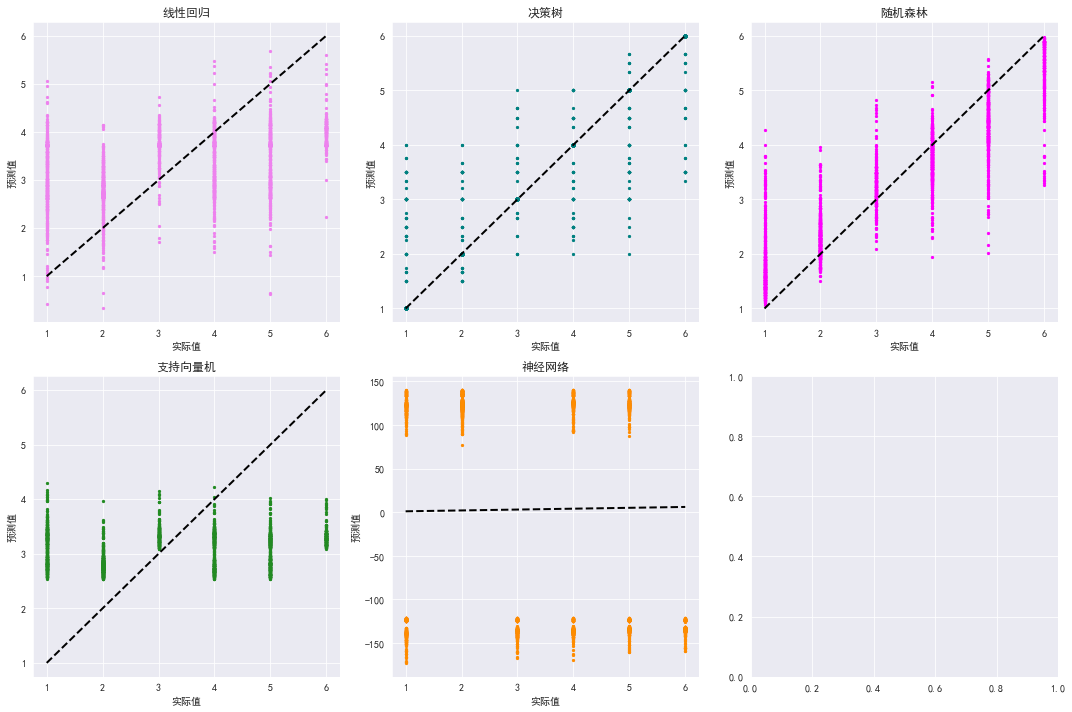

In [28]:
# 假设已经定义了 X, Y

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X, Y)
LR_y_pred = model.predict(X)

# 输出线性回归模型评价结果
print('线性回归评价结果：')
# 计算均方误差和R^2评价
print("MSE", mean_squared_error(Y, LR_y_pred))
print("R^2", r2_score(Y, LR_y_pred))

axs[0][0].scatter(Y, LR_y_pred, color='violet', s = 5)
axs[0][0].plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=2)
axs[0][0].set_xlabel('实际值')
axs[0][0].set_ylabel('预测值')
axs[0][0].set_title('线性回归')

# 构建决策树回归模型
from sklearn.tree import DecisionTreeRegressor
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X, Y)
tree_y_pred = tree_model.predict(X)

# 输出决策树模型评价结果
print('决策树模型评价结果：')
# 计算均方误差和R^2评价
print("MSE", mean_squared_error(Y, tree_y_pred))
print("R^2", r2_score(Y, tree_y_pred))

axs[0][1].scatter(Y, tree_y_pred, color='teal', s = 5)
axs[0][1].plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=2)
axs[0][1].set_xlabel('实际值')
axs[0][1].set_ylabel('预测值')
axs[0][1].set_title('决策树')

# 构建随机森林回归模型
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, Y)
rf_y_pred = rf_model.predict(X)

# 输出随机森林模型评价结果
print('随机森林模型评价结果：')
# 计算均方误差和R^2评价
print("MSE", mean_squared_error(Y, rf_y_pred))
print("R^2", r2_score(Y, rf_y_pred))

axs[0][2].scatter(Y, rf_y_pred, color='magenta', s = 5)
axs[0][2].plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=2)
axs[0][2].set_xlabel('实际值')
axs[0][2].set_ylabel('预测值')
axs[0][2].set_title('随机森林')

# 构建支持向量机回归模型
from sklearn.svm import SVR
svm_model = SVR()
svm_model.fit(X, Y)
svm_y_pred = svm_model.predict(X)

# 输出支持向量机模型评价结果
print('支持向量机模型评价结果：')
# 计算均方误差和R^2评价
print("MSE", mean_squared_error(Y, svm_y_pred))
print("R^2", r2_score(Y, svm_y_pred))

axs[1][0].scatter(Y, svm_y_pred, color='forestgreen', s = 5)
axs[1][0].plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=2)
axs[1][0].set_xlabel('实际值')
axs[1][0].set_ylabel('预测值')
axs[1][0].set_title('支持向量机')

# 构建神经网络回归模型
from sklearn.neural_network import MLPRegressor
mlp_model = MLPRegressor(random_state=42)
mlp_model.fit(X, Y)
mlp_y_pred = mlp_model.predict(X)

# 输出神经网络模型评价结果
print('神经网络模型评价结果：')
# 计算均方误差和R^2评价
print("MSE", mean_squared_error(Y, mlp_y_pred))
print("R^2", r2_score(Y, mlp_y_pred))

axs[1][1].scatter(Y, mlp_y_pred, color='darkorange', s = 5)
axs[1][1].plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=2)
axs[1][1].set_xlabel('实际值')
axs[1][1].set_ylabel('预测值')
axs[1][1].set_title('神经网络')

plt.tight_layout()
plt.show()


算法：
线性回归（最小二乘法）

变量：
自变量X：{ 总运行时间，总生产数量，总不合格数量，平均生产效率，设备综合故障率，物料推送效率，填装效率，加盖效率，拧盖效率，生产总周期数，合格率 }；因变量Y：{ 工龄 }

https://www.spsspro.com/s/84af164888584fd4917d33afa9b6b2e4

In [29]:
import sys
!{sys.executable} -m pip install shap -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [30]:
import shap
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题

# 初始化SHAP模型
explainer = shap.Explainer(tree_model)

# 计算SHAP值
shap_values = explainer(X)

In [31]:
shap_df = pd.DataFrame(shap_values.values, columns=X.columns)

In [32]:
# 输出每个特征的SHAP值（绝对值）
features=[]
abs_mean_shap_values=[]
for i, feature in enumerate(X.columns):
    abs_mean_shap_value = np.abs(shap_df.values[:, i]).mean()
    features.append(feature)
    abs_mean_shap_values.append(abs_mean_shap_value)
aa=pd.DataFrame(features,columns=['features'])
aa['shap_values']=abs_mean_shap_values
aa.sort_values(by='shap_values', ascending=False)

features  shap_values
8      拧盖效率     0.642153
6      填装效率     0.348192
5    物料推送效率     0.316735
7      加盖效率     0.228781
4   设备综合故障率     0.226579
3    平均生产效率     0.189052
0     总运行时间     0.161067
9    生产总周期数     0.142790
1     总生产数量     0.100427
2    总不合格数量     0.030212
10      合格率     0.025278

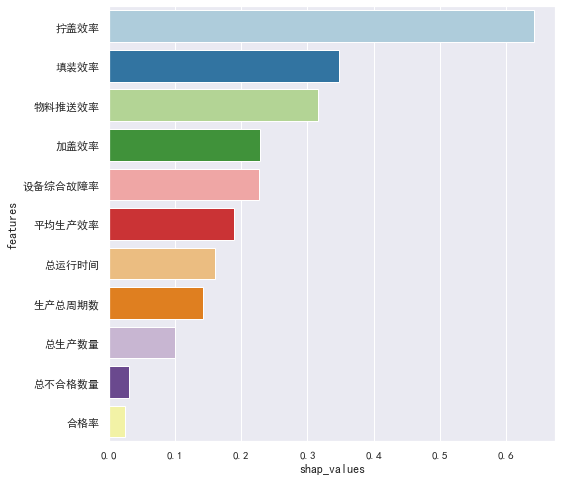

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
 
plt.rcParams['font.sans-serif'] = ['SimHei']  
# Matplotlib中设置字体-黑体，解决Matplotlib中文乱码问题
plt.rcParams['axes.unicode_minus'] = False    
# 解决Matplotlib坐标轴负号'-'显示为方块的问题
sns.set(font='SimHei')                        
# Seaborn中设置字体-黑体，解决Seaborn中文乱码问题
a_sorted = aa.sort_values(by='shap_values', ascending=False)

# 设置图表大小，例如设置为宽10英寸，高6英寸
plt.figure(figsize=(8, 8))
# 使用Seaborn绘制柱状图

pal = sns.color_palette("Paired", 11)
sns.barplot(x='shap_values', y='features', data=a_sorted.reset_index(), orient='h', palette=pal)

# 显示图形
plt.show()

In [34]:

# 初始化SHAP模型
explainer = shap.Explainer(tree_model)

shap.initjs() #初始化JS
shap_values = explainer.shap_values(X) #计算每个样本的每个特征的SHAP值

1


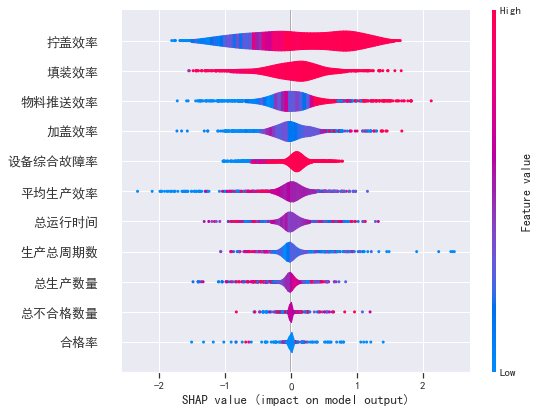

In [45]:
print(1)
shap.summary_plot(shap_values, X[X.columns], plot_type='violin')